## "Ukraine Vs. Russia: Twitter Sentiment Analysis"

#### Importing Dependencies:  
To perform the analysis, we will import the required libraries.

In [20]:
from textblob import TextBlob
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import re
import string
import seaborn as sns
from PIL import Image
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

### Dataset Collection:
Our project will analyze tweets collected from Kaggle [refer to https://www.kaggle.com/datasets/foklacu/ukraine-war-tweets-dataset-65-days/discussion]. These tweets were gathered between January 1st, 2022 and March 6th, 2022, capturing both the period leading up to and the height of the invasion of Ukraine. The dataset contains up to 5,000 tweets collected each day using specific search keywords:
‘Ukraine war’, ‘Ukraine troops’, ‘Ukraine border’, ‘Ukraine NATO’, ‘StandwithUkraine’, ‘Russian troops’, 
‘Russian border Ukraine’, ‘Russia invade’. 

The information is organized into eight comma-separated files (CSV), each corresponding to a specific search term. These files are then loaded and analyzed using Pandas Dataframe. 

In [22]:
tweets = pd.read_csv("archive\\Russia_invade.csv")

# Reading other CSV files into separate DataFrames
dataframe_list = [
    pd.read_csv("archive\\Russian_border_Ukraine.csv"),
    pd.read_csv("archive\\Russian_troops.csv"),
    pd.read_csv("archive\\StandWithUkraine.csv"),
    pd.read_csv("archive\\Ukraine_border.csv"),
    pd.read_csv("archive\\Ukraine_nato.csv"),
    pd.read_csv("archive\\Ukraine_troops.csv"),
    pd.read_csv("archive\\Ukraine_war.csv"),
]

#and finally we will stack all the dataframes using concat fucntion(keeping axis =0(default), ignore_index=0 to reset
#the indexes)
tweets = pd.concat([tweets] + dataframe_list, ignore_index=True)

In [5]:
tweets.head() #pri

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,Searh
0,snscrape.modules.twitter.Tweet,https://twitter.com/pat_ianni/status/150025982...,2022-03-05 23:59:50+00:00,JOE BIDEN SAYS HOW DO WE GET TO A PLACE WHERE ...,JOE BIDEN SAYS HOW DO WE GET TO A PLACE WHERE ...,1500259827154505728,"{'_type': 'snscrape.modules.twitter.User', 'us...",14,26,99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Russia invade
1,snscrape.modules.twitter.Tweet,https://twitter.com/luxeprogressive/status/150...,2022-03-05 23:59:05+00:00,@ProfPaulPoast He doesn’t have to like it but ...,@ProfPaulPoast He doesn’t have to like it but ...,1500259636863246336,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,2,...,NaN,NaN,1.500259e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,Russia invade
2,snscrape.modules.twitter.Tweet,https://twitter.com/spielblog/status/150025947...,2022-03-05 23:58:26+00:00,@SemproniusT @RichardHanania And if NATO is th...,@SemproniusT @RichardHanania And if NATO is th...,1500259474040180738,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,...,NaN,NaN,1.500259e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,Russia invade
3,snscrape.modules.twitter.Tweet,https://twitter.com/JumboSlunce/status/1500259...,2022-03-05 23:58:20+00:00,@jakehase @Groutandgo @MysticAura_ @SkylarJord...,@jakehase @Groutandgo @MysticAura_ @SkylarJord...,1500259447742115841,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,...,NaN,NaN,1.500248e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,Russia invade
4,snscrape.modules.twitter.Tweet,https://twitter.com/ronanmcmanus/status/150025...,2022-03-05 23:58:17+00:00,@2_4_5T_2_4_D @carolecadwalla @estellecostanza...,@2_4_5T_2_4_D @carolecadwalla @estellecostanza...,1500259435142340608,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,...,NaN,NaN,1.500258e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,Russia invade


#### Removing Duplicates:

In [23]:
tweets.drop_duplicates(inplace=True)
#it iterates through the tweets and compares each row 
#with all preceding rows. By default, it considers all columns in the DataFrame for 
#determining duplicates. Since inplace=True is set to True, the identified duplicate 
#rows are permanently deleted from the original tweets DataFrame.

### Preprocessing : 

In [7]:
tweets['date'] = tweets.date.str.slice(0, 10)  #it will remove the time part from date column

In [8]:
#to print the dates for which tweets were collected
print(tweets['date'].unique())   

#to print the languages in which tweets were done
print(tweets["lang"].unique())

['2022-03-05' '2022-03-04' '2022-03-03' '2022-03-02' '2022-03-01'
 '2022-02-28' '2022-02-27' '2022-02-26' '2022-02-25' '2022-02-24'
 '2022-02-23' '2022-02-22' '2022-02-21' '2022-02-20' '2022-02-19'
 '2022-02-18' '2022-02-17' '2022-02-16' '2022-02-15' '2022-02-14'
 '2022-02-13' '2022-02-12' '2022-02-11' '2022-02-10' '2022-02-09'
 '2022-02-08' '2022-02-07' '2022-02-06' '2022-02-05' '2022-02-04'
 '2022-02-03' '2022-02-02' '2022-02-01' '2022-01-31' '2022-01-30'
 '2022-01-29' '2022-01-28' '2022-01-27' '2022-01-26' '2022-01-25'
 '2022-01-24' '2022-01-23' '2022-01-22' '2022-01-21' '2022-01-20'
 '2022-01-19' '2022-01-18' '2022-01-17' '2022-01-16' '2022-01-15'
 '2022-01-14' '2022-01-13' '2022-01-12' '2022-01-11' '2022-01-10'
 '2022-01-09' '2022-01-08' '2022-01-07' '2022-01-06' '2022-01-05'
 '2022-01-04' '2022-01-03' '2022-01-02' '2022-01-01' '2021-12-31']
['en' 'pt' 'zh' 'nl' 'it' 'es' 'de' 'ca' 'cy' 'fr' 'tr' 'ro' 'pl' 'cs'
 'ja' 'in' 'hi' 'und' 'sv' 'tl' 'et' 'fi' 'da' 'no' 'el' 'ht' 'ru' 'ar

In [24]:
print(tweets.shape) #will return the dimension of the dataset(no. of rows and no. of columns)

(1313818, 29)


In [25]:
tweets = tweets[tweets['lang'] == 'en']   #to keep only tweets made in english

print("After keeping tweets in only english language: ", end = '')

print(tweets.shape) #changed dimension of the dataset

After keeping tweets in only english language: (1204218, 29)


In [10]:
# Removing RT, Punctuation etc
def remove_rt(x): return re.sub('RT @\w+: ', " ", x)

def rt(x): return re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x)

tweets["content"] = tweets.content.map(remove_rt).map(rt)
tweets["content"] = tweets.content.str.lower()

### Sentiment Analysis:

In [15]:
#the line below add two extra columns polarity and subjectivity

#sentiment method of TextBlob returns a dictionary with polarity (positive or negative sentiment) and subjectivity 
#(opinionated or factual content) values.
tweets[['polarity', 'subjectivity']] = tweets['content'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
                                                

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

for index, row in tweets.iterrows():
    score = sia.polarity_scores(row['content']) #to analyze the sentiment of the sentence and
                                                #return the sentiment scores, including positive, negative, neutral,
                                                #and compound scores using NLTK's analyzer
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
 
        
    tweets.loc[index, 'neg'] = neg 
    tweets.loc[index, 'neu'] = neu
    tweets.loc[index, 'pos'] = pos
    tweets.loc[index, 'compound'] = comp

tweets.head()

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,hashtags,cashtags,Searh,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,snscrape.modules.twitter.Tweet,https://twitter.com/pat_ianni/status/150025982...,2022-03-05,joe biden says how do we get to a place where ...,JOE BIDEN SAYS HOW DO WE GET TO A PLACE WHERE ...,1500259827154505728,"{'_type': 'snscrape.modules.twitter.User', 'us...",14,26,99,...,NaN,NaN,Russia invade,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
1,snscrape.modules.twitter.Tweet,https://twitter.com/luxeprogressive/status/150...,2022-03-05,he doesn t have to like it but it s up to th...,@ProfPaulPoast He doesn’t have to like it but ...,1500259636863246336,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,2,...,NaN,NaN,Russia invade,0.000000,1.000000,positive,0.000,0.838,0.162,0.7876
2,snscrape.modules.twitter.Tweet,https://twitter.com/spielblog/status/150025947...,2022-03-05,and if nato is the aggressor then maybe ru...,@SemproniusT @RichardHanania And if NATO is th...,1500259474040180738,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,...,NaN,NaN,Russia invade,0.300000,0.200000,negative,0.183,0.746,0.070,-0.6486
3,snscrape.modules.twitter.Tweet,https://twitter.com/JumboSlunce/status/1500259...,2022-03-05,zelensky was not put in power by a ...,@jakehase @Groutandgo @MysticAura_ @SkylarJord...,1500259447742115841,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,...,NaN,NaN,Russia invade,-0.300000,0.200000,negative,0.155,0.806,0.039,-0.5994
4,snscrape.modules.twitter.Tweet,https://twitter.com/ronanmcmanus/status/150025...,2022-03-05,4 5t 2 4 d or is your point that ukraine...,@2_4_5T_2_4_D @carolecadwalla @estellecostanza...,1500259435142340608,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,...,NaN,NaN,Russia invade,-0.013393,0.611607,positive,0.062,0.858,0.080,0.1506


In [16]:
#to see the result of above operations
tweets[["content", "sentiment", "polarity", "subjectivity", "neg", "neu", "pos"]].head(5)  

,content,sentiment,polarity,subjectivity,neg,neu,pos
0,joe biden says how do we get to a place where ...,neutral,0.000000,0.000000,0.000,1.000,0.000
1,he doesn t have to like it but it s up to th...,positive,0.000000,1.000000,0.000,0.838,0.162
2,and if nato is the aggressor then maybe ru...,negative,0.300000,0.200000,0.183,0.746,0.070
3,zelensky was not put in power by a ...,negative,-0.300000,0.200000,0.155,0.806,0.039
4,4 5t 2 4 d or is your point that ukraine...,positive,-0.013393,0.611607,0.062,0.858,0.080


In [17]:
total_pos = len(tweets.loc[tweets['sentiment'] == "positive"])
total_neg = len(tweets.loc[tweets['sentiment'] == "negative"])
total_neu = len(tweets.loc[tweets['sentiment'] == "neutral"])
total_tweets = len(tweets)
print("Total Positive Tweets % : {:.2f}".format((total_pos/total_tweets)*100))
print("Total Negative Tweets % : {:.2f}".format((total_neg/total_tweets)*100))
print("Total Neutral Tweets % : {:.2f}".format((total_neu/total_tweets)*100))

Total Positive Tweets % : 31.54
Total Negative Tweets % : 54.56
Total Neutral Tweets % : 13.90


##### If we want to display this result using a Pie Chart, then we can do that with the help of the below code snippet –

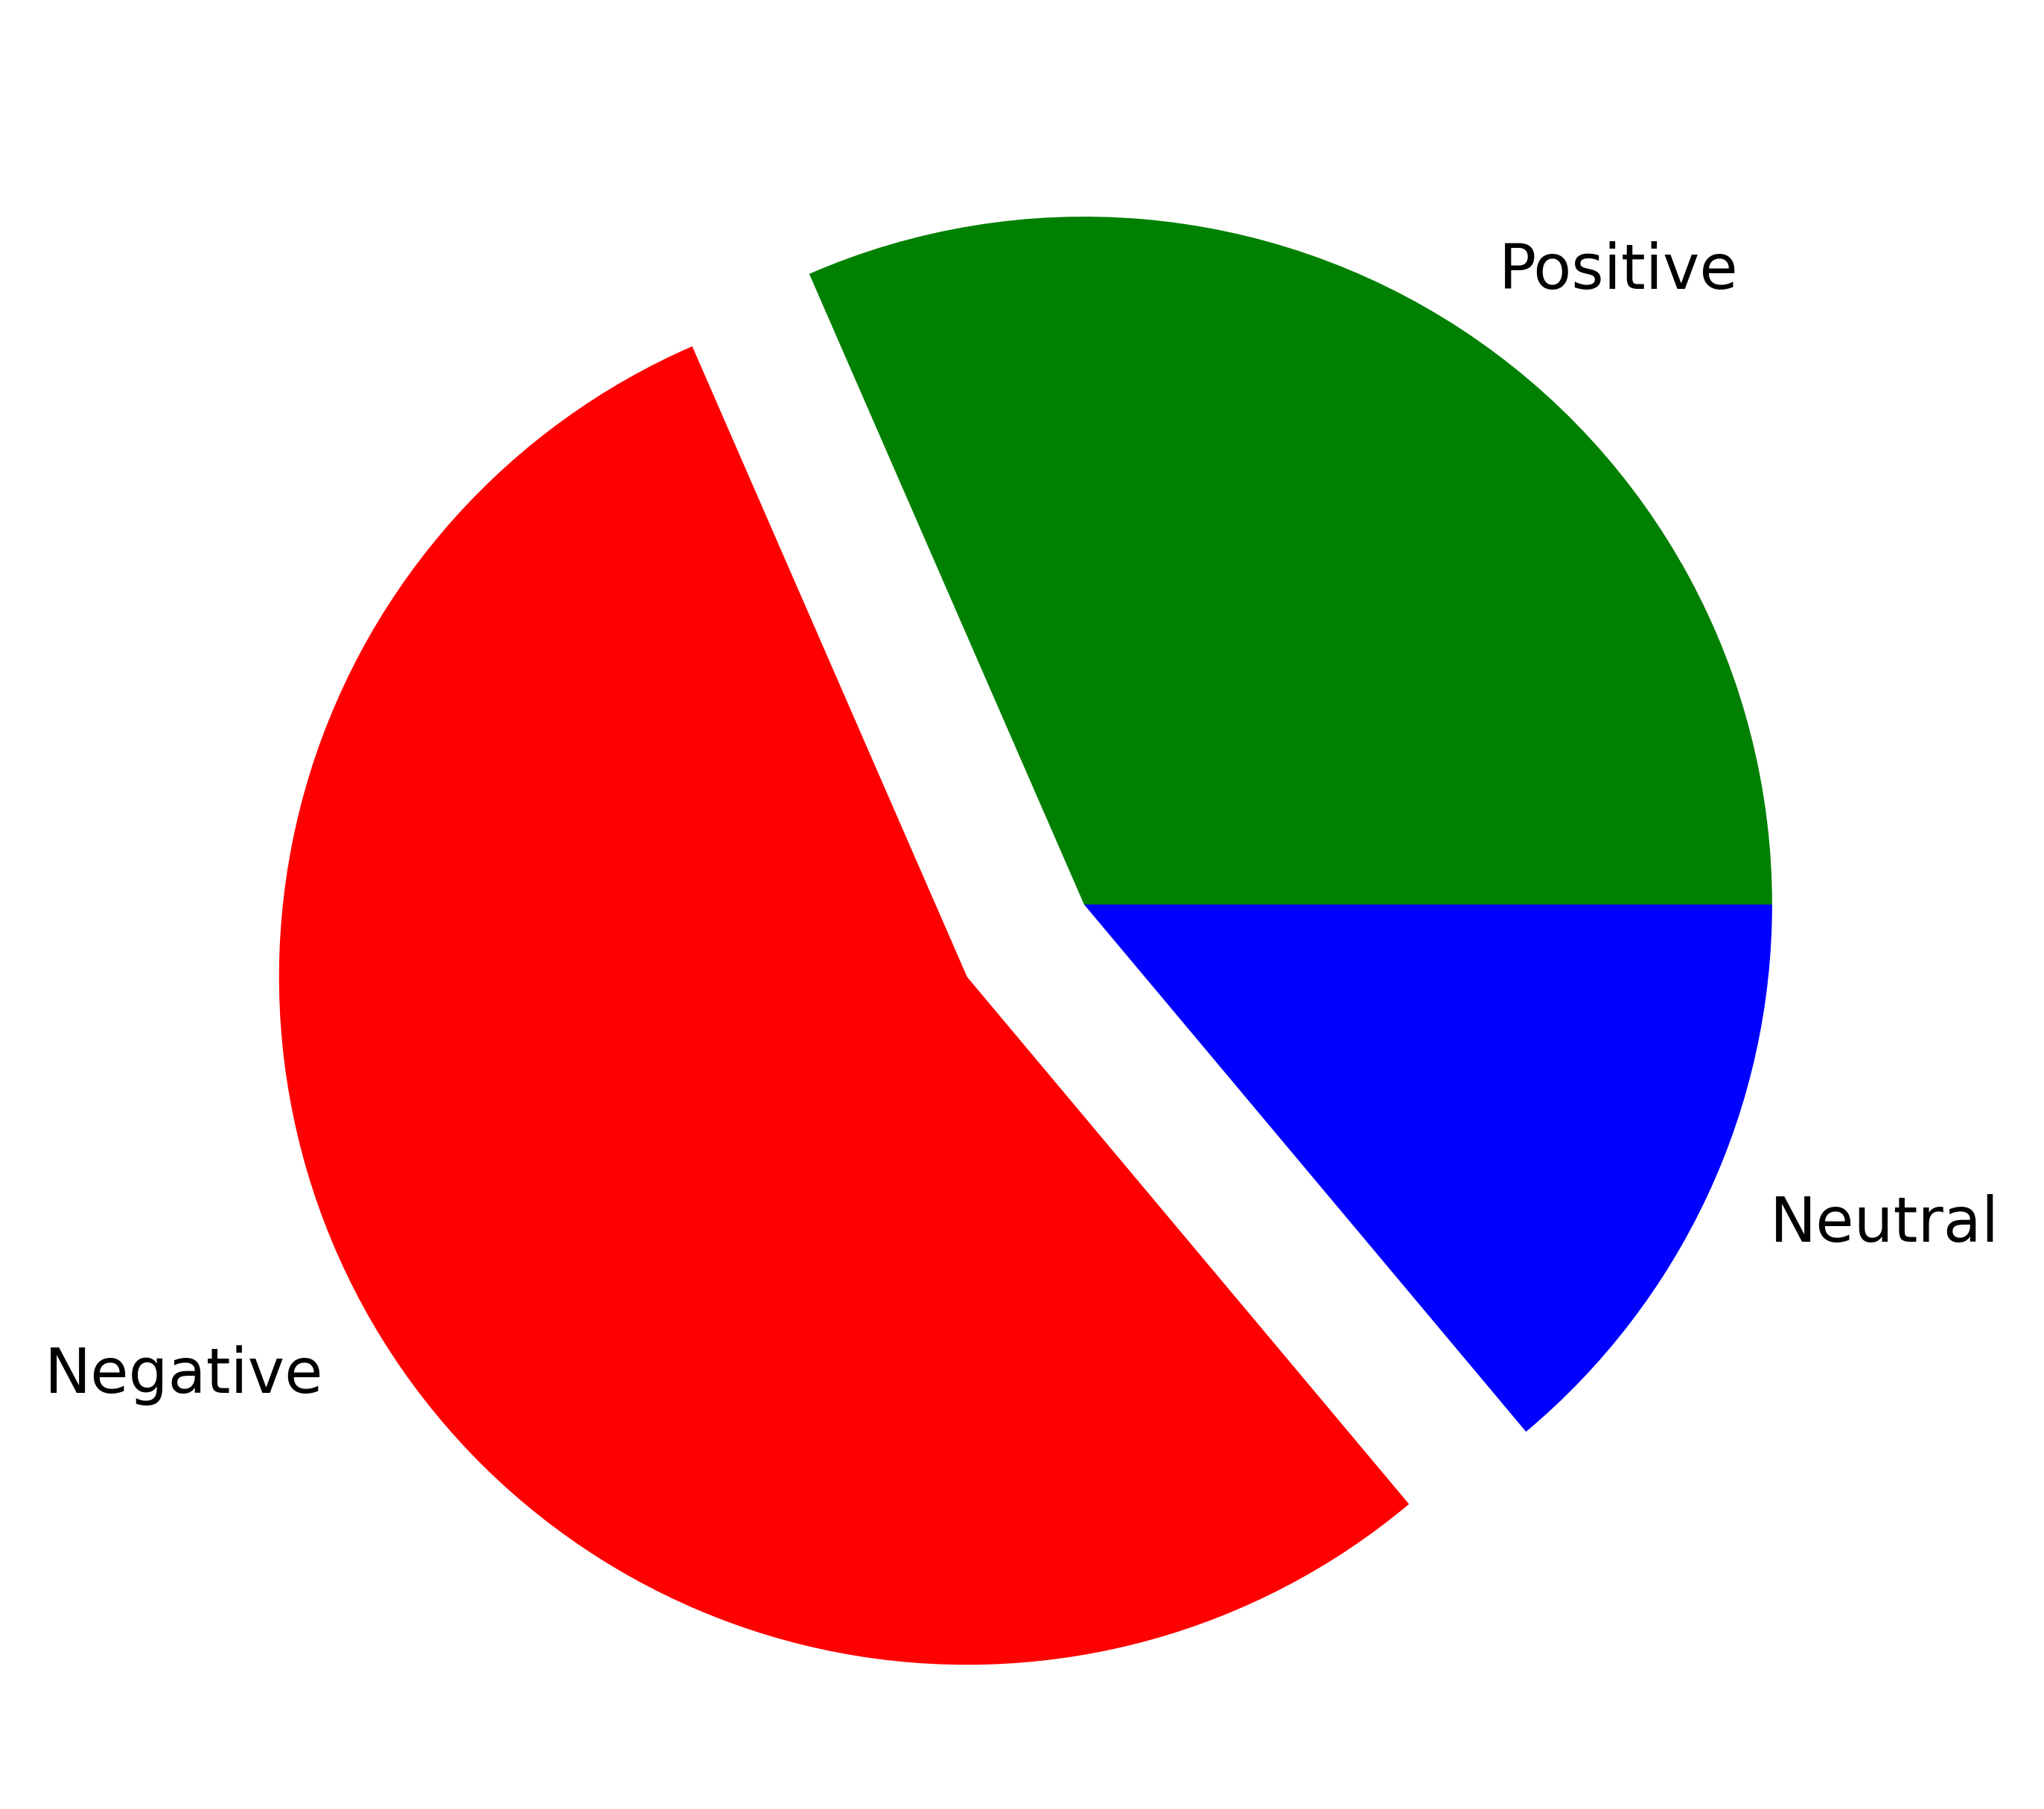

In [18]:
mylabels = ["Positive", "Negative", "Neutral"]
mycolors = ["Green", "Red", "Blue"]

plt.figure(figsize=(8, 5), dpi=600)
myexplode = [0, 0.2, 0]
plt.pie([total_pos, total_neg, total_neu], colors=mycolors, labels=mylabels, explode=myexplode)
plt.show()

### Now, If we want to see the sentiments over 65 days using an N-gram.

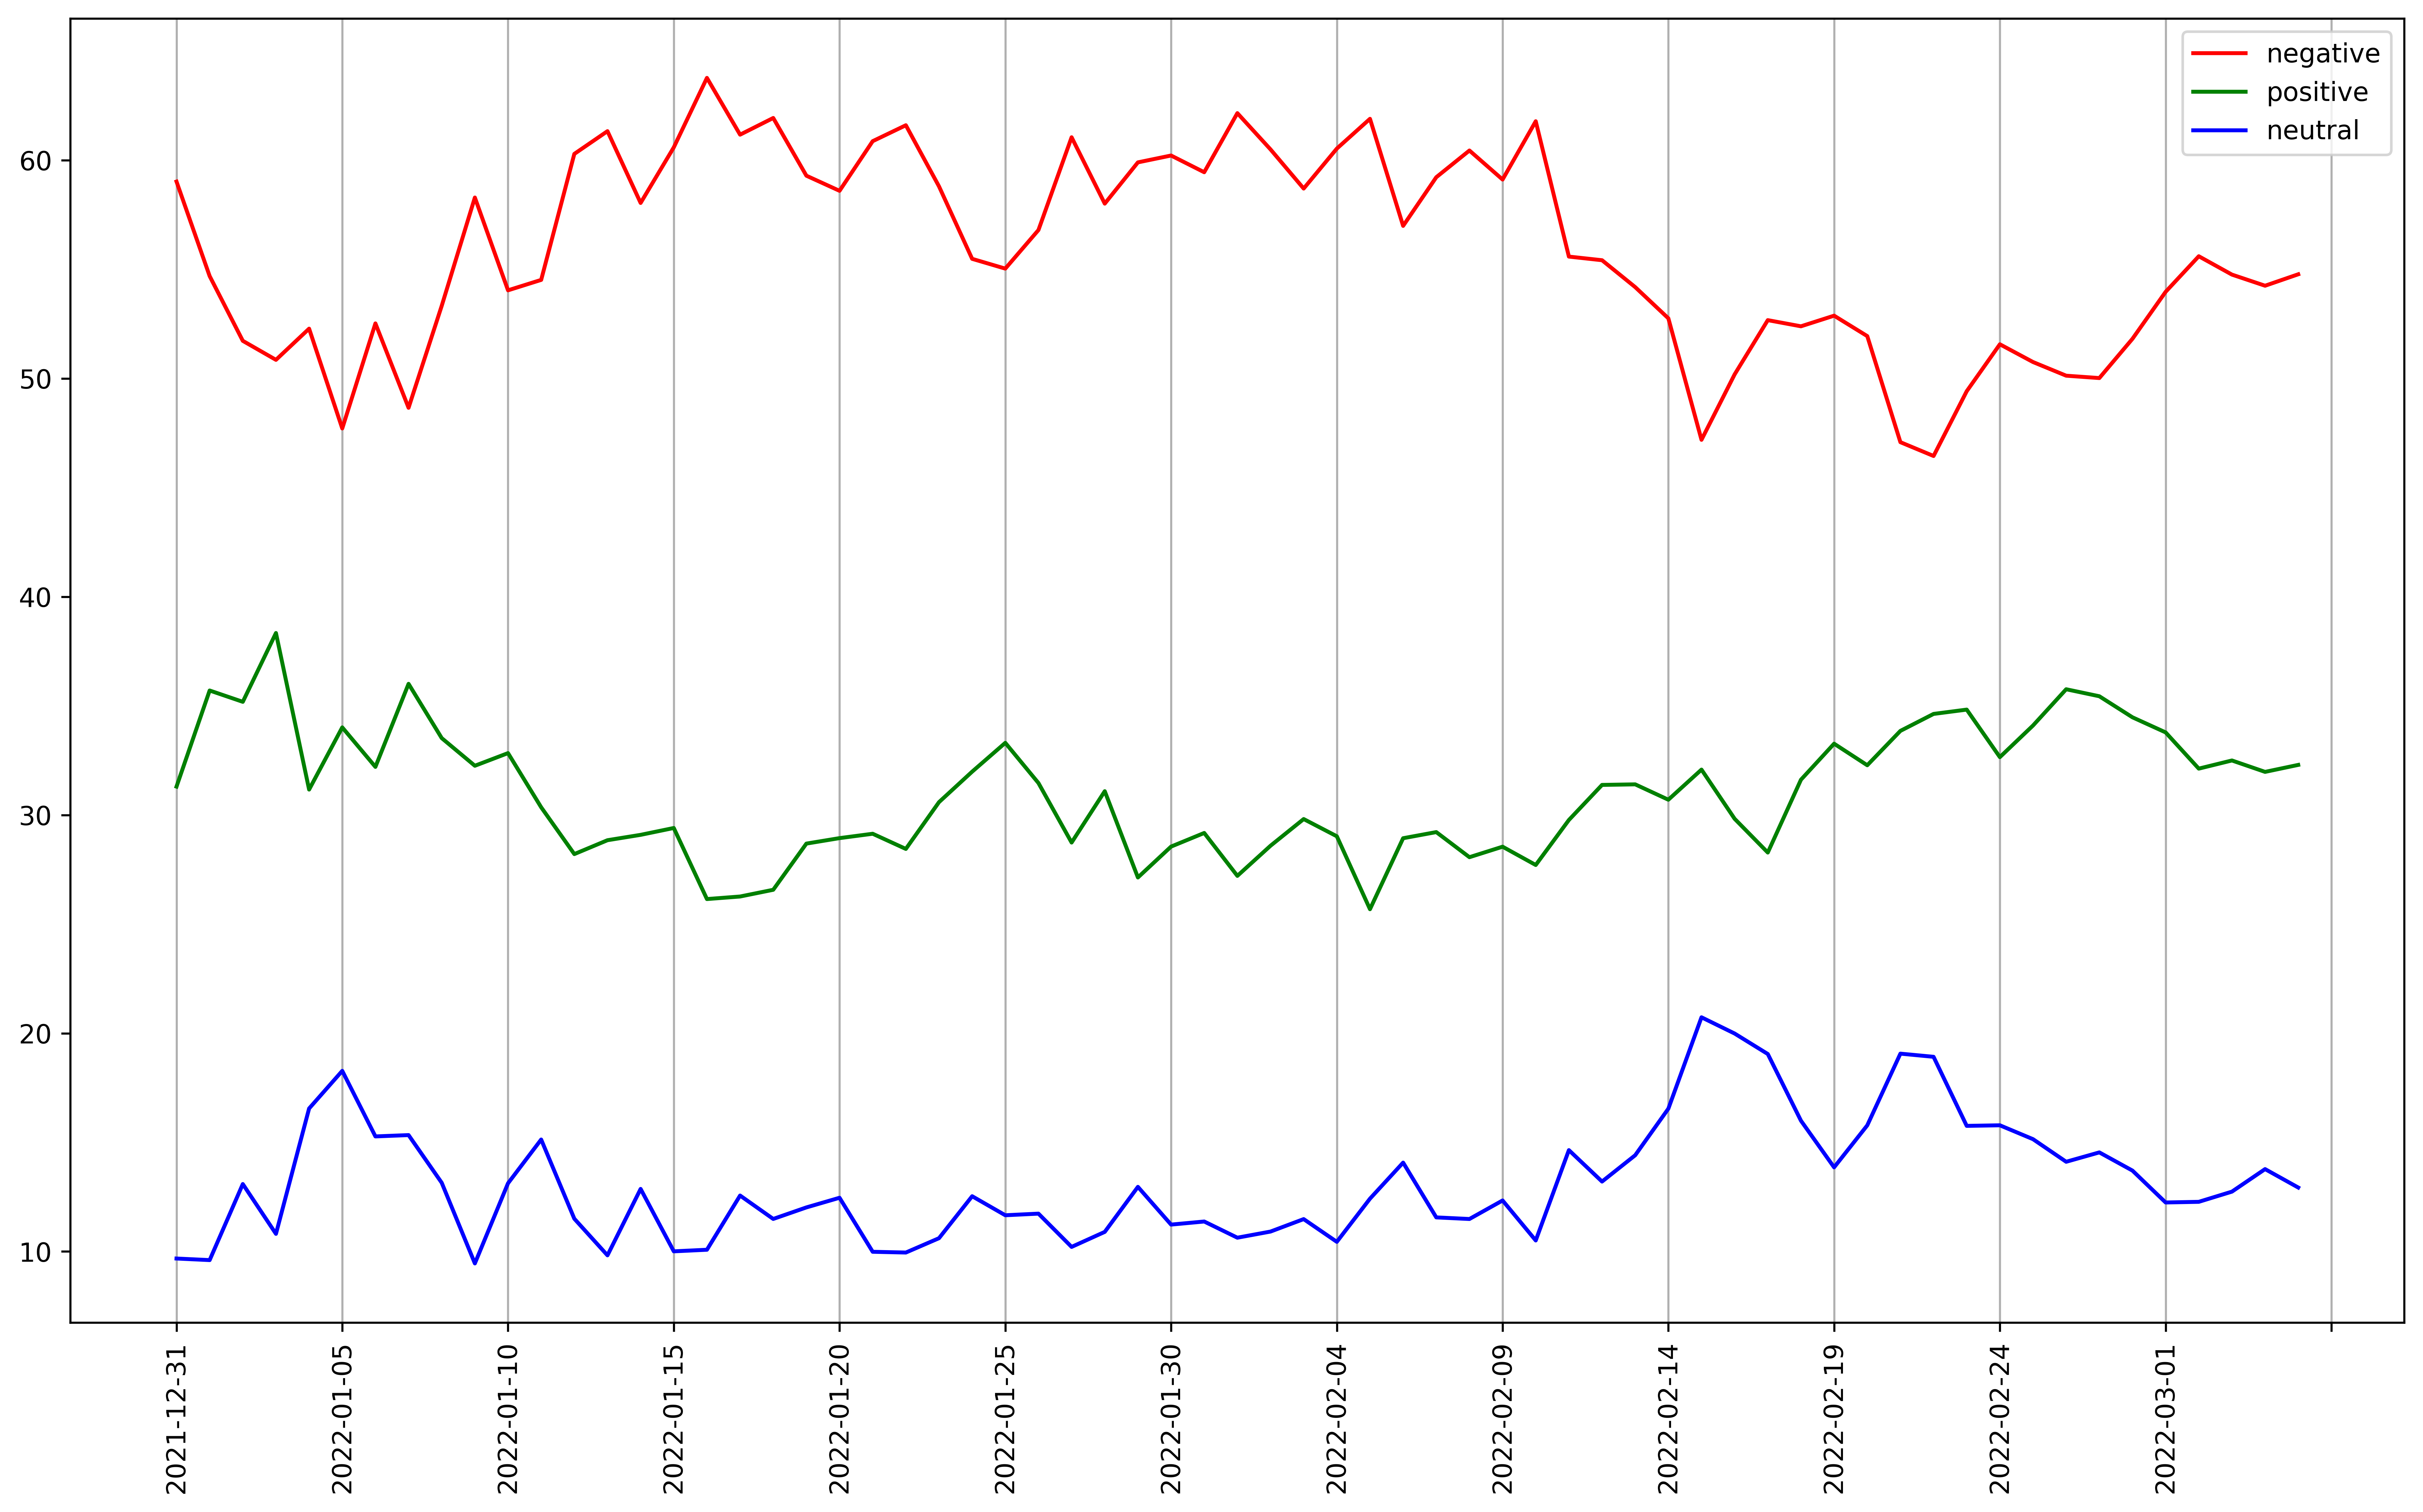

In [19]:
pos_list = []
neg_list = []
neu_list = []
for i in tweets["date"].unique():
    temp = tweets[tweets["date"] == i]
    positive_temp = temp[temp["sentiment"] == "positive"]
    negative_temp = temp[temp["sentiment"] == "negative"]
    neutral_temp = temp[temp["sentiment"] == "neutral"]
    pos_list.append(((positive_temp.shape[0]/temp.shape[0])*100, i))
    neg_list.append(((negative_temp.shape[0]/temp.shape[0])*100, i))
    neu_list.append(((neutral_temp.shape[0]/temp.shape[0])*100, i))

neu_list = sorted(neu_list, key=lambda x: x[1])
pos_list = sorted(pos_list, key=lambda x: x[1])
neg_list = sorted(neg_list, key=lambda x: x[1])

x_cord_neg = []
y_cord_neg = []

x_cord_pos = []
y_cord_pos = []

x_cord_neu = []
y_cord_neu = []

for i in neg_list:
    x_cord_neg.append(i[0])
    y_cord_neg.append(i[1])


for i in pos_list:
    x_cord_pos.append(i[0])
    y_cord_pos.append(i[1])

for i in neu_list:
    x_cord_neu.append(i[0])
    y_cord_neu.append(i[1])


plt.figure(figsize=(16, 9), dpi=600) # Push new figure on stack

plt.plot(y_cord_neg, x_cord_neg, label="negative", color="red")
plt.plot(y_cord_pos, x_cord_pos, label="positive", color="green")
plt.plot(y_cord_neu, x_cord_neu, label="neutral", color="blue")
plt.xticks(np.arange(0, len(tweets["date"].unique()) + 1, 5))
plt.xticks(rotation=90)
plt.grid(axis='x')

plt.legend()